# Assignment 4 - MDP 2 (Frozen Lake)

By Dongbo Zhang 

@dzhang48@gatech.edu



In [422]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import hiive.mdptoolbox.mdp as mdp
import hiive.mdptoolbox.example as example
import numpy as np
import seaborn as sns
plt.style.use('ggplot')
import gym

# Small Size Problem

In [3]:
# Use GYM to generate FrozenLake 4X4 
env = gym.make('FrozenLake-v0')
env.reset()
env.render()

num_states = env.observation_space.n
num_actions = env.action_space.n

print (num_states)
print (num_actions)

# Generate transition matrix and reward matrix

R = np.zeros((num_states, num_actions))
P = np.zeros((num_actions, num_states, num_states))

for s, values in env.P.items():
    for a, val in values.items():
        for probability, s_next, reward, complete in val:
            P[a, s, s_next] += probability
            R[s, a] = reward


SFFF
FHFH
FFFH
HFFG
16
4


## Policy Evalutaion

In [63]:
# Below policy evaluation functions run_episode & evaluate_policy are from the OpemAI website.
# https://gym.openai.com/evaluations/eval_4VyQBhXMRLmG9y9MQA5ePA/
def run_episode(env, policy, episode_len=100):
    total_reward = 0
    miss_goal = 0
    obs = env.reset()
    for t in range(episode_len):
        # env.render()
        action = policy[obs]
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            if reward == 0:
                miss_goal = 1
            # print('Epside finished after {} timesteps.'.format(t+1))
            break
    return total_reward, miss_goal


def evaluate_policy(env, policy, n_episodes=100):
    total_rewards, total_miss = 0.0, 0.0
    for _ in range(n_episodes):
        total_reward, miss = run_episode(env, policy)
        total_rewards += total_reward
        total_miss += miss
    return total_rewards / n_episodes, total_miss / n_episodes



## Policy Iteration


In [314]:
def run_pi(P, R, discount, max_iter, n_state):
    pi = mdp.PolicyIteration(P, R, discount, max_iter=max_iter)
    pi_res = pi.run()
    #print (pi_res)
    iterations, reward, max_reward, mean_reward, error, runtime = [], [], [], [], [], []
    for dict_ in pi_res:
        iterations.append(dict_['Iteration'])
        
        reward.append(dict_['Reward'])
        
        
        mean_reward.append(dict_['Mean V'])
        
        max_reward.append(dict_['Max V'])
        
        error.append(dict_['Error'])
        
        runtime.append(dict_['Time'])
        

    pi_res_df = pd.DataFrame({'Iteration': iterations, 'Reward': reward, 'Max_V': max_reward,
                              'Mean_V':mean_reward,
                             'Error': error, 'Run Time': runtime})
    pi_value_df = pd.DataFrame({'Num_State': range(1, n_state+1 ), 
                               'Reward': pi.V})

    return pi_res_df, pi_value_df, pi

discount_rates = [0.1, 0.5, 0.9, 0.95, 0.99]
MAX_ITERATION = 500
pi_policies = {}
pi_analysis = {'gamma': discount_rates, 'converge iter':[], 'time':[]}
pi_res_iter = pd.DataFrame()
pi_res_state = pd.DataFrame()
for rate in discount_rates:
    pi_result, pi_val_res, pi = run_pi(P, R, rate, MAX_ITERATION, num_states)
    pi_policies[rate] = pi.policy
    
    pi_analysis['converge iter'].append(pi.iter)
    pi_analysis['time'].append(pi.time)
    pi_result['gamma'] = rate
    pi_val_res['gamma'] = rate
    pi_res_iter = pi_res_iter.append(pi_result)
    pi_res_state = pi_res_state.append(pi_val_res)
    

In [315]:
pi_res_iter.sort_values('Iteration', ascending=False)

,Iteration,Reward,Max_V,Mean_V,Error,Run Time,gamma
499,500,2.171021,2.171021,0.616516,4.440892e-16,0.270285,0.95
498,499,2.171021,2.171021,0.616516,4.440892e-16,0.269646,0.95
497,498,2.171021,2.171021,0.616516,4.440892e-16,0.269104,0.95
496,497,2.171021,2.171021,0.616516,4.440892e-16,0.268579,0.95
495,496,2.171021,2.171021,0.616516,4.440892e-16,0.268037,0.95
...,...,...,...,...,...,...,...
0,1,1.428571,1.428571,0.135736,4.285714e-01,0.000487,0.90
0,1,1.492537,1.492537,0.152862,4.925373e-01,0.000498,0.99
0,1,1.200000,1.200000,0.090621,2.000000e-01,0.000737,0.50
0,1,1.463415,1.463415,0.144725,4.634146e-01,0.000502,0.95


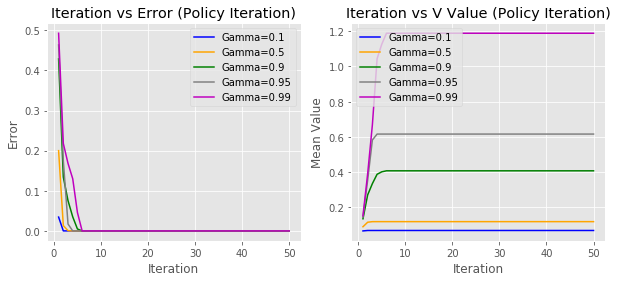

In [350]:
colors = ['b','orange','g', 'gray', 'm']
#max_iter = min(MAX_ITERATION, max(pi_res_iter['Iteration']) + 10)
MAX_ITER_PLOT = 50
fig, ax = plt.subplots(1,2, figsize=(10,4))
for i in range(len(discount_rates)):
    tmp = pi_res_iter[(pi_res_iter.gamma == discount_rates[i])&(pi_res_iter['Iteration']<=MAX_ITER_PLOT)][['Iteration','Error','Mean_V']]
    fill = tmp.iloc[-1,:]
    if tmp.shape[0] < MAX_ITER_PLOT:
        tmp = tmp.append([fill]*(MAX_ITER_PLOT - tmp.shape[0]))
    tmp['Iteration'] = range(1, tmp.shape[0]+1)
    ax[0].plot(tmp['Iteration'], tmp['Error'], color=colors[i], label="Gamma={}".format(round(discount_rates[i],3)))
    ax[1].plot(tmp['Iteration'], tmp['Mean_V'],color=colors[i], label="Gamma={}".format(round(discount_rates[i],3)))
ax[0].set_title('Iteration vs Error (Policy Iteration)')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Error')
ax[0].legend()

ax[1].set_title('Iteration vs V Value (Policy Iteration)')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mean Value')
ax[1].legend()
plt.savefig("pi_plot1.png", dpi=100)
plt.show()

### Evaluate the optimal PI policies

In [317]:
NUM_EPISODES = 10000
PI_eval_res = {'Gamma':[], 'Average Total Rewards':[], 'Success Rate':[]}
for gamma in discount_rates:
    total_reward, miss_pct = evaluate_policy(env, pi_policies[gamma], n_episodes=NUM_EPISODES)
    PI_eval_res['Gamma'].append(round(gamma, 3))
    PI_eval_res['Average Total Rewards'].append(total_reward)
    PI_eval_res['Success Rate'].append(round(1-miss_pct, 3))

PI_eval_res_df = pd.DataFrame(PI_eval_res) 

In [323]:
PI_eval_analysis = pd.merge(PI_eval_res_df, pd.DataFrame(pi_analysis), left_on='Gamma', right_on='gamma')
PI_eval_analysis

,Gamma,Average Total Rewards,Success Rate,gamma,converge iter,time
0,0.10,0.4382,0.438,0.10,4,0.002839
1,0.50,0.4398,0.440,0.50,4,0.002422
2,0.90,0.7204,0.720,0.90,6,0.003227
3,0.95,0.7295,0.730,0.95,500,0.270362
4,0.99,0.7448,0.745,0.99,7,0.003758


  Gamma  Average Total Rewards  Success Rate
0   0.1                 0.4465         0.447
1   0.5                 0.4523         0.452
2   0.9                 0.7368         0.737
3  0.95                 0.7266         0.727
4  0.99                 0.7457         0.746


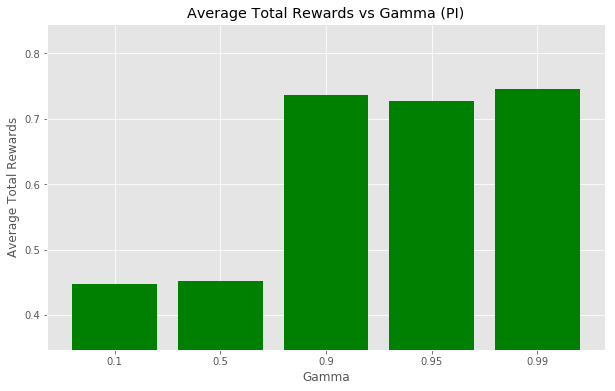

In [299]:
def plot_eval_policy(eval_perf, perf_col, method, hp_cols=[], plot_type = 'bar'):
    if plot_type == 'bar':
        if len(hp_cols) > 0:
            for hp in hp_cols:
                eval_perf[hp] = eval_perf[hp].astype(str)
                print (eval_perf)
                fig, ax = plt.subplots(1,1,figsize=(10,6))
                ax.bar(eval_perf[hp], eval_perf[perf_col], color='g')
                ax.set_title('{} vs {} ({})'.format(perf_col, hp, method))
                ax.set_ylabel(perf_col)
                ax.set_xlabel(hp)
                ax.set_ylim([min(eval_perf[perf_col]) - 0.1, max(eval_perf[perf_col]) + 0.1])
                plt.show()
            
plot_eval_policy(PI_eval_res_df, 'Average Total Rewards', 'PI', hp_cols=['Gamma'], plot_type = 'bar')

## Value Iteration

In [338]:
def run_vi(P, R, discount, max_iter, n_state):
    vi = mdp.ValueIteration(P, R, discount, max_iter=max_iter)
    vi_res = vi.run()

    #print (vi_res)
    iterations, reward, max_reward, mean_reward, error, runtime = [], [], [], [], [], []
    for dict_ in vi_res:
        iterations.append(dict_['Iteration'])
        
        reward.append(dict_['Reward'])
        
        max_reward.append(dict_['Max V'])
        
        mean_reward.append(dict_['Mean V'])
        
        error.append(dict_['Error'])
        
        runtime.append(dict_['Time'])
        

    vi_res_df = pd.DataFrame({'Iteration': iterations, 'Reward': reward, 'Max_V': max_reward,
                              'Mean_V':mean_reward,
                             'Error': error, 'Run Time': runtime})
    vi_value_df = pd.DataFrame({'Num_State': range(1, n_state+1 ), 
                               'Reward': vi.V})

    return vi_res_df, vi_value_df, vi


vi_policies = {}
vi_analysis = {'gamma': discount_rates, 'converge iter':[], 'time':[]}
vi_res_iter = pd.DataFrame()
vi_res_state = pd.DataFrame()
for rate in discount_rates:
    vi_result, vi_val_res, vi = run_vi(P, R, rate, MAX_ITERATION, num_states)
    vi_policies[rate] = vi.policy
    vi_analysis['converge iter'].append(vi.iter)
    vi_analysis['time'].append(vi.time)
    vi_result['gamma'] = rate
    vi_val_res['gamma'] = rate
    vi_res_iter = vi_res_iter.append(vi_result)
    vi_res_state = vi_res_state.append(vi_val_res)
    

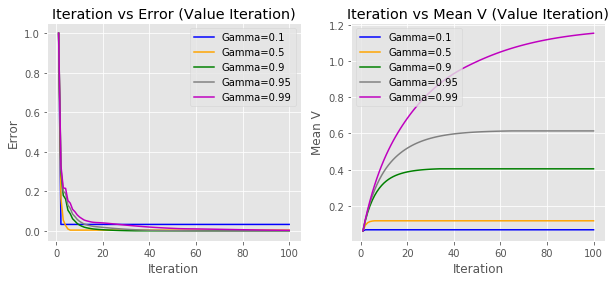

In [351]:
colors = ['b','orange','g', 'gray', 'm']
MAX_ITER_PLOT = 100
fig, ax = plt.subplots(1,2, figsize=(10,4))
for i in range(len(discount_rates)):
    tmp = vi_res_iter[(vi_res_iter.gamma == discount_rates[i])&(vi_res_iter['Iteration']<=MAX_ITER_PLOT)][['Iteration','Error','Mean_V']]
    fill = tmp.iloc[-1,:]
    if tmp.shape[0] < MAX_ITER_PLOT:
        tmp = tmp.append([fill]*(MAX_ITER_PLOT - tmp.shape[0]))
    tmp['Iteration'] = range(1, tmp.shape[0]+1)
    ax[0].plot(tmp['Iteration'], tmp['Error'], color=colors[i], label="Gamma={}".format(round(discount_rates[i],3)))
    ax[1].plot(tmp['Iteration'], tmp['Mean_V'],color=colors[i], label="Gamma={}".format(round(discount_rates[i],3)))
ax[0].set_title('Iteration vs Error (Value Iteration)')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Error')
ax[0].legend()

ax[1].set_title('Iteration vs Mean V (Value Iteration)')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mean V')
ax[1].legend()
plt.savefig("vi_plot1.png", dpi=100)
plt.show()

### Evaluate optimal VI policy

In [327]:
NUM_EPISODES = 10000
VI_eval_res = {'Gamma':[], 'Average Total Rewards':[], 'Success Rate':[]}
for gamma in discount_rates:
    total_reward, miss_pct = evaluate_policy(env, vi_policies[gamma], n_episodes=NUM_EPISODES)
    VI_eval_res['Gamma'].append(round(gamma, 3))
    VI_eval_res['Average Total Rewards'].append(total_reward)
    VI_eval_res['Success Rate'].append(round(1-miss_pct, 3))

VI_eval_res_df = pd.DataFrame(VI_eval_res) 

In [328]:
VI_eval_analysis = pd.merge(VI_eval_res_df, pd.DataFrame(vi_analysis), left_on='Gamma', right_on='gamma')
VI_eval_analysis

,Gamma,Average Total Rewards,Success Rate,gamma,converge iter,time
0,0.10,0.0000,0.000,0.10,2,0.000302
1,0.50,0.2113,0.211,0.50,6,0.000543
2,0.90,0.7260,0.726,0.90,34,0.002749
3,0.95,0.7303,0.730,0.95,65,0.005184
4,0.99,0.7440,0.744,0.99,203,0.016002


  Gamma  Average Total Rewards  Success Rate
0   0.1                 0.0000         0.000
1   0.5                 0.2113         0.211
2   0.9                 0.7260         0.726
3  0.95                 0.7303         0.730
4  0.99                 0.7440         0.744


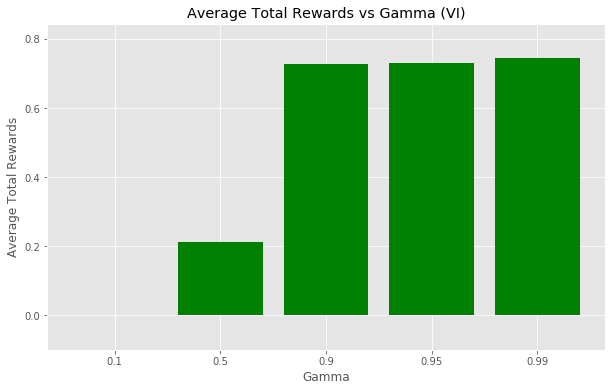

In [329]:
plot_eval_policy(VI_eval_res_df, 'Average Total Rewards', 'VI', hp_cols=['Gamma'], plot_type = 'bar')

## Compare PI and VI

Visualize the two optimal policies. They are the same

In [336]:
GAMMA = 0.99
print ("PI Policy")
print (np.reshape(pi_policies[GAMMA], (4,4)))
print ("VI Policy")
print (np.reshape(vi_policies[GAMMA], (4,4)))

PI Policy
[[0 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]
VI Policy
[[0 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


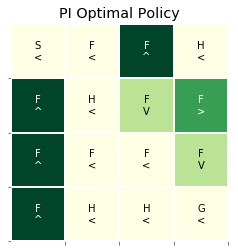

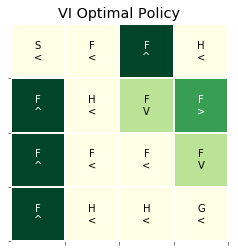

In [420]:
import matplotlib.cm as cm
import matplotlib.ticker as ticker
def plot_policy(policy, env_map, title, save_fig=False):
    # This plot policy function is created based on the discussion in 
    #https://stackoverflow.com/questions/22158377/colorplot-of-2d-array-with-text-labels
    ##LEFT = 0
    #DOWN = 1
    #RIGHT = 2
    #UP = 3
    action_map = {0:'<', 1:'V', 2:'>', 3:'^'}
    
    shape = env_map.shape
    policy = (np.reshape(policy, shape))
    nx, ny = policy.shape
    indx, indy = np.arange(nx), np.arange(ny)
    x, y = np.meshgrid(indx, indy)

    fig, ax = plt.subplots()
    ax.imshow(policy.T,  cmap=cm.YlGn) # plot grid values

    for xval, yval in zip(x.flatten(), y.flatten()):
        pval = policy[xval, yval]
        action = str(env_map[xval, yval].decode("utf-8")) + "\n"+action_map[pval]
        c = 'w' if pval > 1 else 'k' # if dark-green, change text color to white
        ax.text(xval, yval, action, color=c, va='center', ha='center')
    ax.set_xticks(indx+0.5) # offset x/y ticks so gridlines run on border of boxes
    ax.set_yticks(indy+0.5)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_xticklabels(empty_string_labels)
    ax.set_yticklabels(empty_string_labels)
    ax.grid(ls='-', lw=2)
    ax.set_title(title)
    if save_fig:
        plt.savefig(title+'.png', dpi=100)
    plt.show()
    
env_map = env.desc
plot_policy(pi_policies[GAMMA], env_map, "PI Optimal Policy", save_fig=True)
plot_policy(vi_policies[GAMMA], env_map, "VI Optimal Policy", save_fig=True)

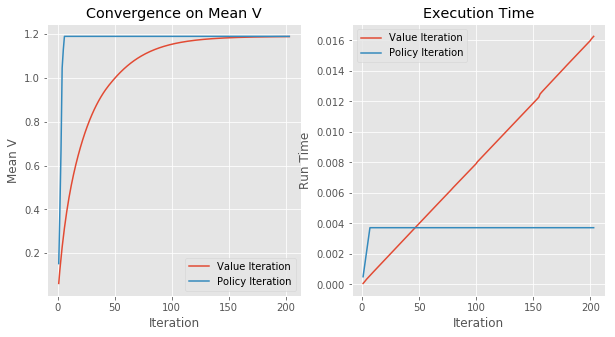

In [421]:
# Plot the convergence and time required for VI/PI
fig, ax = plt.subplots(1,2,figsize=(10,5))
vi_compare = vi_res_iter[vi_res_iter.gamma==GAMMA]
pi_compare = pi_res_iter[pi_res_iter.gamma==GAMMA]
max_iter = max(vi_compare['Iteration'].max(), pi_compare['Iteration'].max())
if vi_compare['Iteration'].max() < max_iter:
    fill = vi_compare.iloc[-1,:]
    vi_compare = vi_compare.append([fill]*(max_iter - vi_compare.shape[0]))
    vi_compare['Iteration'] = range(1, vi_compare.shape[0]+1)
if pi_compare['Iteration'].max() < max_iter:
    fill = pi_compare.iloc[-1,:]
    pi_compare = pi_compare.append([fill]*(max_iter - pi_compare.shape[0]))
    pi_compare['Iteration'] = range(1, pi_compare.shape[0]+1)

ax[0].plot(vi_compare['Iteration'],vi_compare['Mean_V'], label='Value Iteration')
ax[0].plot(pi_compare['Iteration'],pi_compare['Mean_V'], label='Policy Iteration')
ax[1].plot(vi_compare['Iteration'],vi_compare['Run Time'], label='Value Iteration')
ax[1].plot(pi_compare['Iteration'],pi_compare['Run Time'], label='Policy Iteration')
ax[0].set_title("Convergence on Mean V")
ax[0].set_ylabel("Mean V")
ax[0].set_xlabel("Iteration")
ax[0].legend()
ax[1].set_title("Execution Time")
ax[1].set_ylabel("Run Time")
ax[1].set_xlabel("Iteration")
ax[1].legend()
plt.savefig('frozenlake_pi_vs_vi.png', dpi=100)
plt.show()


## Q Learning

In [562]:
np.random.seed(15)
def run_ql(P, R, discount, alpha, epsilon, alpha_decay, epsilon_decay, max_iter, n_state):
    ql = mdp.QLearning(P, R, discount, alpha=alpha, alpha_decay=alpha_decay, epsilon=epsilon,
                       epsilon_decay=epsilon_decay, n_iter=max_iter, run_stat_frequency=100)
    ql_res = ql.run()

    iterations, reward, max_reward, mean_reward, error, runtime = [], [], [], [], [], []
    for dict_ in ql_res:
        iterations.append(dict_['Iteration'])
        
        reward.append(dict_['Reward'])
        
        max_reward.append(dict_['Max V'])
        
        mean_reward.append(dict_['Mean V'])
        
        error.append(dict_['Error'])
        
        runtime.append(dict_['Time'])
        

    ql_res_df = pd.DataFrame({'Iteration': iterations, 'Reward': reward, 'Max_V': max_reward,
                              'Mean_V':mean_reward,'Error': error, 'Run Time': runtime})
    ql_value_df = pd.DataFrame({'Num_State': range(1, n_state+1 ), 
                               'Reward': ql.V})


    return ql_res_df, ql_value_df, ql

#ql_result, ql_val_res = run_ql(P, R, 0.9, 20000, num_states)
MAX_ITERATION_QL = 500000
ql_analysis = {'gamma': [], 'alpha':[], 'epsilon':[], 'avg reward':[], 'time':[]}
ql_policies = {}
ql_res_iter = pd.DataFrame()
ql_res_state = pd.DataFrame()

alpha_list = [0.1, 0.3, 0.5, 0.7, 0.9]
epsilon_list = [1, 0.7, 0.5, 0.1]

for alpha in alpha_list:
    print (alpha)
    for gamma in discount_rates:
        for epsilon in epsilon_list:
            #print (gamma, alpha, epsilon)
            ql_result, ql_val_res, ql = run_ql(P, R, rate, alpha=alpha, epsilon=epsilon, alpha_decay=1.0, epsilon_decay=0.995,
                                                      max_iter=MAX_ITERATION_QL, n_state=num_states)
            ql_policies[(gamma, alpha, epsilon)] = ql.policy
            ql_analysis['gamma'].append(gamma)
            ql_analysis['alpha'].append(alpha)
            ql_analysis['epsilon'].append(epsilon)
            ql_analysis['avg reward'].append(np.array(ql.V).mean())
            ql_analysis['time'].append(ql.time)
            ql_result['gamma'] = gamma
            ql_result['alpha'] = alpha
            ql_result['epsilon'] = epsilon
            ql_val_res['gamma'] = gamma
            ql_val_res['alpha'] = alpha
            ql_val_res['epsilon'] = epsilon
            ql_res_iter = ql_res_iter.append(ql_result)
            ql_res_state = ql_res_state.append(ql_val_res)




0.1
0.3
0.5
0.7
0.9


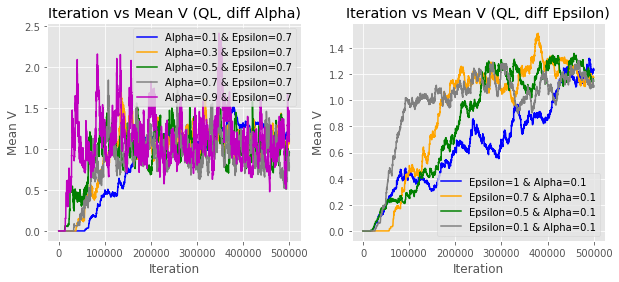

In [604]:
#ql_res_iter[(ql_res_iter.gamma == 0.99)&(ql_res_iter.alpha==0.5)&(ql_res_iter.epsilon==1.0)][['Max_V','Mean_V']].plot()

GAMMA = 0.99
colors = ['b','orange','g', 'gray', 'm']
colors_1 = ['olive','red','black', 'y']

fig, ax = plt.subplots(1,2, figsize=(10,4))
for i in range(len(alpha_list)):
    tmp = ql_res_iter[(ql_res_iter.gamma == GAMMA)&(ql_res_iter.epsilon==.7)&
                      (ql_res_iter['alpha']==alpha_list[i])][['Iteration','Error','Mean_V']]
    ax[0].plot(tmp['Iteration'], tmp['Mean_V'],color=colors[i], label="Alpha={} & Epsilon=0.7".format(round(alpha_list[i],3)))
    
for i in range(len(epsilon_list)):
    tmp = ql_res_iter[(ql_res_iter.gamma == GAMMA)&(ql_res_iter.epsilon==epsilon_list[i])&
                      (ql_res_iter['alpha']==0.1)][['Iteration','Error','Mean_V']]
    ax[1].plot(tmp['Iteration'], tmp['Mean_V'],color=colors[i], label="Epsilon={} & Alpha=0.1".format(round(epsilon_list[i],3)))
    #tmp = ql_res_iter[(ql_res_iter.gamma == GAMMA)&(ql_res_iter.epsilon==epsilon_list[i])&
    #                  (ql_res_iter['alpha']==0.5)][['Iteration','Error','Mean_V']]
    #ax[1].plot(tmp['Iteration'], tmp['Mean_V'],color=colors_1[i], linestyle='--', label="Epsilon={} & Alpha=0.5".format(round(epsilon_list[i],3)))

    
ax[0].set_title('Iteration vs Mean V (QL, diff Alpha)')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Mean V')
ax[0].legend()

ax[1].set_title('Iteration vs Mean V (QL, diff Epsilon)')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mean V')
ax[1].legend()
plt.savefig("frozen_lake_ql_plot1.png", dpi=100)
plt.show()

### Evaluate the optimal QLearning policy

In [565]:
QL_eval_res = {'Gamma':[], 'Alpha':[], 'Epsilon':[], 'Average Total Rewards':[], 'Success Rate':[]}

for alpha in alpha_list:
    for gamma in discount_rates:
        for epsilon in epsilon_list:
            total_reward, miss_pct = evaluate_policy(env, ql_policies[(gamma, alpha, epsilon)], n_episodes=NUM_EPISODES)
            QL_eval_res['Gamma'].append(round(gamma, 3))
            QL_eval_res['Alpha'].append(round(alpha,3))
            QL_eval_res['Epsilon'].append(epsilon)
            QL_eval_res['Average Total Rewards'].append(total_reward)
            QL_eval_res['Success Rate'].append(round(1-miss_pct, 3))

QL_eval_res_df = pd.DataFrame(QL_eval_res) 

In [567]:
Best_QL_by_Gamma = QL_eval_res_df.groupby('Gamma')['Average Total Rewards'].max().reset_index()

   Gamma  Average Total Rewards
0    0.1                 0.7416
1    0.5                 0.7444
2    0.7                 0.7456
3    0.9                 0.7464
4   0.99                 0.7495
5  0.995                 0.7448


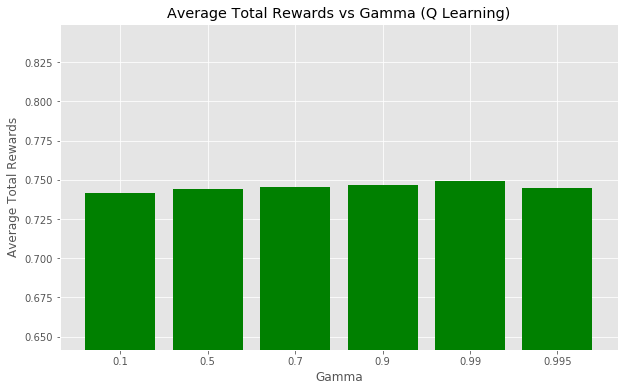

In [568]:
plot_eval_policy(Best_QL_by_Gamma, 'Average Total Rewards', 'Q Learning', hp_cols=['Gamma'], plot_type = 'bar')

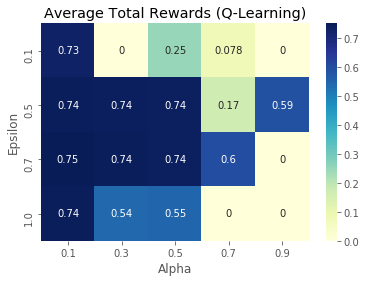

In [569]:
QL_comp = pd.pivot_table(QL_eval_res_df[QL_eval_res_df.Gamma==0.99], values='Average Total Rewards', columns='Alpha', index='Epsilon')
fig, ax = plt.subplots()
ax = sns.heatmap(QL_comp, annot=True,  cmap="YlGnBu")
ax.set_title("Average Total Rewards (Q-Learning)")
plt.savefig("frozen_lake_ql_heatmap1.png")

Plot optimal Q-Learning policy

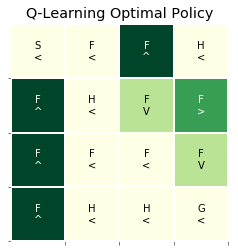

In [570]:
best_alpha = 0.1
best_epsilon=0.7
plot_policy(ql_policies[(GAMMA, best_alpha,best_epsilon )], env_map, "Q-Learning Optimal Policy", save_fig=True)

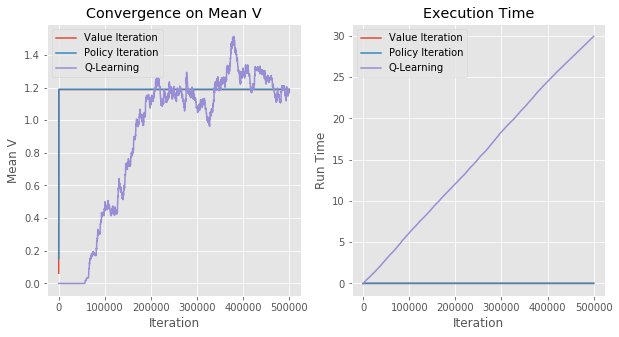

In [574]:
# Plot the convergence and time required for VI, PI and Q-Learning
fig, ax = plt.subplots(1,2,figsize=(10,5))
vi_compare = vi_res_iter[vi_res_iter.gamma==GAMMA]
pi_compare = pi_res_iter[pi_res_iter.gamma==GAMMA]
ql_compare = ql_res_iter[(ql_res_iter.gamma==GAMMA)&(ql_res_iter.alpha==best_alpha)&(ql_res_iter.epsilon==best_epsilon)]
max_iter = max(vi_compare['Iteration'].max(), pi_compare['Iteration'].max(),  ql_compare['Iteration'].max())
if vi_compare['Iteration'].max() < max_iter:
    fill = vi_compare.iloc[-1,:]
    vi_compare = vi_compare.append([fill]*(max_iter - vi_compare.shape[0]))
    vi_compare['Iteration'] = range(1, vi_compare.shape[0]+1)
if pi_compare['Iteration'].max() < max_iter:
    fill = pi_compare.iloc[-1,:]
    pi_compare = pi_compare.append([fill]*(max_iter - pi_compare.shape[0]))
    pi_compare['Iteration'] = range(1, pi_compare.shape[0]+1)

ax[0].plot(vi_compare['Iteration'],vi_compare['Mean_V'], label='Value Iteration')
ax[0].plot(pi_compare['Iteration'],pi_compare['Mean_V'], label='Policy Iteration')
ax[0].plot(ql_compare['Iteration'],ql_compare['Mean_V'], label='Q-Learning')
ax[1].plot(vi_compare['Iteration'],vi_compare['Run Time'], label='Value Iteration')
ax[1].plot(pi_compare['Iteration'],pi_compare['Run Time'], label='Policy Iteration')
ax[1].plot(ql_compare['Iteration'],ql_compare['Run Time'], label='Q-Learning')
ax[0].set_title("Convergence on Mean V")
ax[0].set_ylabel("Mean V")
ax[0].set_xlabel("Iteration")
ax[0].legend()
ax[1].set_title("Execution Time")
ax[1].set_ylabel("Run Time")
ax[1].set_xlabel("Iteration")
ax[1].legend()
plt.savefig('frozenlake_ql_comparison.png', dpi=100)
plt.show()

# Larger size problem

In [575]:
from gym.envs.toy_text.frozen_lake import generate_random_map
np.random.seed(15)
random_map = generate_random_map(size=20, p=0.95)
 
large_env = gym.make("FrozenLake-v0", desc=random_map)
large_env.reset()
large_env.render()


SFFFFFFFFFFFFFFFFFFF
HFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFHFFFFFFFFF
FFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFF
FFFHFFFFFFFFFFFFFFFF
FFHFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFHFFFFF
FHHFFFFFFFFFFHFFFFFH
FFFFFFFHFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFHFFF
FFFFFFFFFHFFFFFHFFFF
HFFFFFFFFFFHFFFFFFFF
FFFHFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFF
FFFFHHFFFFFFFFFFFFFF
FFFHFFFFFFFFFFFFFFHG


In [576]:
# Generate Transition matrix and reward matrix
large_num_states = large_env.observation_space.n
large_num_actions = large_env.action_space.n

print (large_num_states)
print (large_num_actions)

large_R = np.zeros((large_num_states, large_num_actions))
large_P = np.zeros((large_num_actions, large_num_states, large_num_states))

for s, values in large_env.P.items():
    for a, val in values.items():
        for probability, s_next, reward, complete in val:
            large_P[a, s, s_next] += probability
            large_R[s, a] = reward

400
4


## Policy Iteration

In [577]:
discount_rates = [0.1, 0.5, 0.7, 0.9, 0.99, 0.995]
MAX_ITERATION = 1000
large_pi_policies = {}
large_pi_analysis = {'gamma': discount_rates, 'converge iter':[], 'time':[]}
large_pi_res_iter = pd.DataFrame()
large_pi_res_state = pd.DataFrame()
for rate in discount_rates:
    print (rate)
    pi_result, pi_val_res, pi = run_pi(large_P, large_R, rate, MAX_ITERATION, large_num_states)
    large_pi_policies[rate] = pi.policy
    
    large_pi_analysis['converge iter'].append(pi.iter)
    large_pi_analysis['time'].append(pi.time)
    pi_result['gamma'] = rate
    pi_val_res['gamma'] = rate
    large_pi_res_iter = large_pi_res_iter.append(pi_result)
    large_pi_res_state = large_pi_res_state.append(pi_val_res)
    

0.1
0.5
0.7
0.9
0.99
0.995


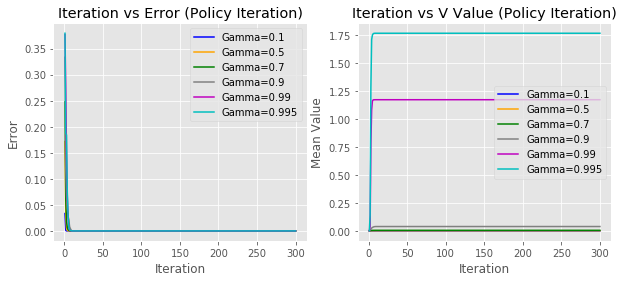

In [596]:
colors = ['b','orange','g', 'gray', 'm','c']
#max_iter = min(MAX_ITERATION, max(pi_res_iter['Iteration']) + 10)
MAX_ITER_PLOT = 300
fig, ax = plt.subplots(1,2, figsize=(10,4))
for i in range(len(discount_rates)):
    tmp = large_pi_res_iter[(large_pi_res_iter.gamma == discount_rates[i])&(large_pi_res_iter['Iteration']<=MAX_ITER_PLOT)][['Iteration','Error','Mean_V']]
    fill = tmp.iloc[-1,:]
    if tmp.shape[0] < MAX_ITER_PLOT:
        tmp = tmp.append([fill]*(MAX_ITER_PLOT - tmp.shape[0]))
    tmp['Iteration'] = range(1, tmp.shape[0]+1)
    ax[0].plot(tmp['Iteration'], tmp['Error'], color=colors[i], label="Gamma={}".format(round(discount_rates[i],3)))
    ax[1].plot(tmp['Iteration'], tmp['Mean_V'],color=colors[i], label="Gamma={}".format(round(discount_rates[i],3)))
ax[0].set_title('Iteration vs Error (Policy Iteration)')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Error')
ax[0].legend()

ax[1].set_title('Iteration vs V Value (Policy Iteration)')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mean Value')
ax[1].legend()
plt.savefig("large_frozen_lake_pi_plot1.png", dpi=100)
plt.show()

### Evaluate optimap PI policy

In [579]:
NUM_EPISODES_LARGE = 1000
large_PI_eval_res = {'Gamma':[], 'Average Total Rewards':[], 'Success Rate':[]}
for gamma in discount_rates:
    total_reward, miss_pct = evaluate_policy(large_env, large_pi_policies[gamma], n_episodes=NUM_EPISODES_LARGE)
    large_PI_eval_res['Gamma'].append(round(gamma, 3))
    large_PI_eval_res['Average Total Rewards'].append(total_reward)
    large_PI_eval_res['Success Rate'].append(round(1-miss_pct, 3))

large_PI_eval_res_df = pd.DataFrame(large_PI_eval_res) 

large_PI_eval_analysis = pd.merge(large_PI_eval_res_df, pd.DataFrame(large_pi_analysis), left_on='Gamma', right_on='gamma')
large_PI_eval_analysis

,Gamma,Average Total Rewards,Success Rate,gamma,converge iter,time
0,0.100,0.101,0.101,0.100,22,4.915237
1,0.500,0.110,0.110,0.500,21,4.829423
2,0.700,0.114,0.114,0.700,21,4.806362
3,0.900,0.119,0.119,0.900,1000,263.381828
4,0.990,0.128,0.128,0.990,1000,296.167192
5,0.995,0.136,0.136,0.995,1000,262.502656


## Value Iteration

In [580]:
large_vi_policies = {}
large_vi_analysis = {'gamma': discount_rates, 'converge iter':[], 'time':[]}
large_vi_res_iter = pd.DataFrame()
large_vi_res_state = pd.DataFrame()
for rate in discount_rates:
    vi_result, vi_val_res, vi = run_vi(large_P, large_R, rate, MAX_ITERATION, large_num_states)
    large_vi_policies[rate] = vi.policy
    large_vi_analysis['converge iter'].append(vi.iter)
    large_vi_analysis['time'].append(vi.time)
    vi_result['gamma'] = rate
    vi_val_res['gamma'] = rate
    large_vi_res_iter = large_vi_res_iter.append(vi_result)
    large_vi_res_state = large_vi_res_state.append(vi_val_res)
    

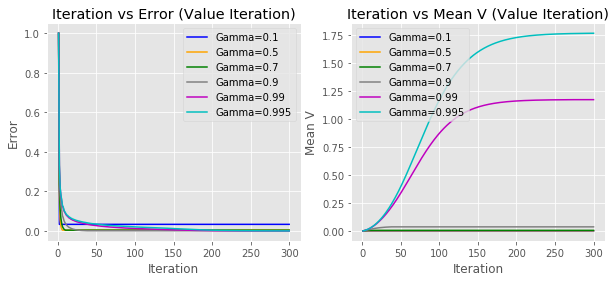

In [595]:
#colors = ['b','orange','g', 'gray', 'm']
MAX_ITER_PLOT = 300
fig, ax = plt.subplots(1,2, figsize=(10,4))
for i in range(len(discount_rates)):
    tmp = large_vi_res_iter[(large_vi_res_iter.gamma == discount_rates[i])&(large_vi_res_iter['Iteration']<=MAX_ITER_PLOT)][['Iteration','Error','Mean_V']]
    fill = tmp.iloc[-1,:]
    if tmp.shape[0] < MAX_ITER_PLOT:
        tmp = tmp.append([fill]*(MAX_ITER_PLOT - tmp.shape[0]))
    tmp['Iteration'] = range(1, tmp.shape[0]+1)
    ax[0].plot(tmp['Iteration'], tmp['Error'], color=colors[i], label="Gamma={}".format(round(discount_rates[i],3)))
    ax[1].plot(tmp['Iteration'], tmp['Mean_V'],color=colors[i], label="Gamma={}".format(round(discount_rates[i],3)))
ax[0].set_title('Iteration vs Error (Value Iteration)')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Error')
ax[0].legend()

ax[1].set_title('Iteration vs Mean V (Value Iteration)')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mean V')
ax[1].legend()
plt.savefig("frozen_lake_large_vi_plot1.png", dpi=100)
plt.show()

In [582]:
large_VI_eval_res = {'Gamma':[], 'Average Total Rewards':[], 'Success Rate':[]}
for gamma in discount_rates:
    total_reward, miss_pct = evaluate_policy(large_env, large_vi_policies[gamma], n_episodes=NUM_EPISODES_LARGE)
    large_VI_eval_res['Gamma'].append(round(gamma, 3))
    large_VI_eval_res['Average Total Rewards'].append(total_reward)
    large_VI_eval_res['Success Rate'].append(round(1-miss_pct, 3))

large_VI_eval_res_df = pd.DataFrame(large_VI_eval_res) 

large_VI_eval_analysis = pd.merge(large_VI_eval_res_df, pd.DataFrame(large_vi_analysis), left_on='Gamma', right_on='gamma')
large_VI_eval_analysis

,Gamma,Average Total Rewards,Success Rate,gamma,converge iter,time
0,0.100,0.000,0.000,0.100,2,0.000974
1,0.500,0.000,0.000,0.500,6,0.008454
2,0.700,0.000,0.000,0.700,10,0.004440
3,0.900,0.055,0.055,0.900,38,0.016762
4,0.990,0.131,0.131,0.990,278,0.172688
5,0.995,0.115,0.115,0.995,348,0.301345


In [592]:
GAMMA = 0.99
print ("PI Policy")
#print (np.reshape(large_pi_policies[GAMMA], (20,20)))
print ("VI Policy")
#print (np.reshape(large_vi_policies[GAMMA], (20,20)))

PI Policy
VI Policy


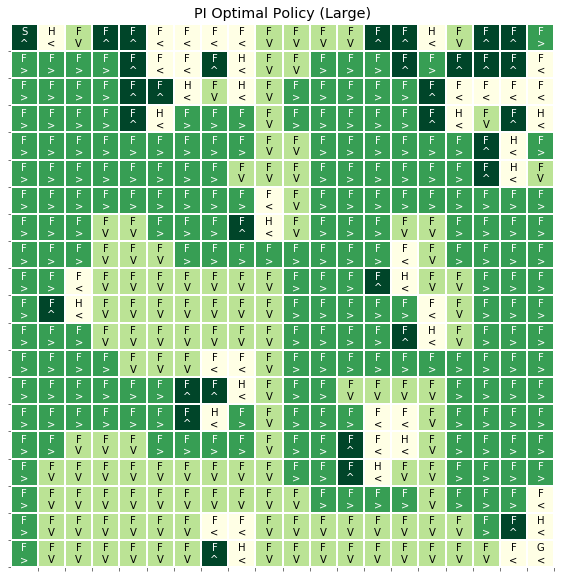

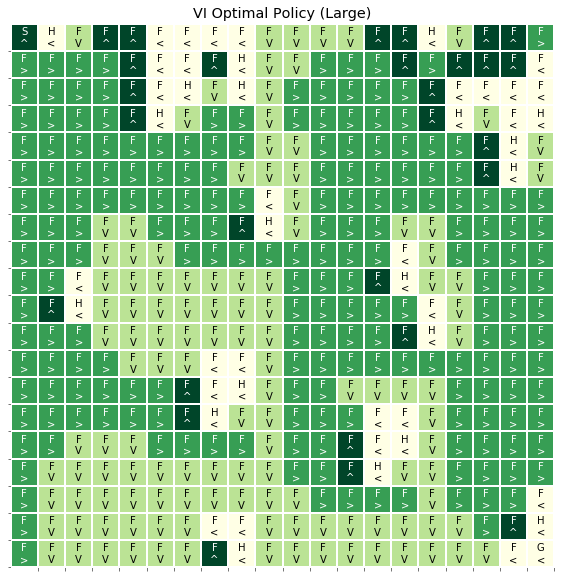

In [588]:
large_env_map = large_env.desc
def plot_policy(policy, env_map, title, save_fig=False, figsize=(5,5)):
    # This plot policy function is created based on the discussion in 
    #https://stackoverflow.com/questions/22158377/colorplot-of-2d-array-with-text-labels
    ##LEFT = 0
    #DOWN = 1
    #RIGHT = 2
    #UP = 3
    action_map = {0:'<', 1:'V', 2:'>', 3:'^'}
    
    shape = env_map.shape
    policy = (np.reshape(policy, shape))
    nx, ny = policy.shape
    indx, indy = np.arange(nx), np.arange(ny)
    x, y = np.meshgrid(indx, indy)

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(policy.T,  cmap=cm.YlGn) # plot grid values

    for xval, yval in zip(x.flatten(), y.flatten()):
        pval = policy[xval, yval]
        action = str(env_map[xval, yval].decode("utf-8")) + "\n"+action_map[pval]
        c = 'w' if pval > 1 else 'k' # if dark-green, change text color to white
        ax.text(xval, yval, action, color=c, va='center', ha='center')
    ax.set_xticks(indx+0.5) # offset x/y ticks so gridlines run on border of boxes
    ax.set_yticks(indy+0.5)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_xticklabels(empty_string_labels)
    ax.set_yticklabels(empty_string_labels)
    ax.grid(ls='-', lw=2)
    ax.set_title(title)
    if save_fig:
        plt.savefig(title+'.png', dpi=100)
    plt.show()
plot_policy(large_pi_policies[GAMMA], large_env_map, "PI Optimal Policy (Large)", save_fig=True, figsize=(10,10))
plot_policy(large_vi_policies[GAMMA], large_env_map, "VI Optimal Policy (Large)", save_fig=True, figsize=(10,10))

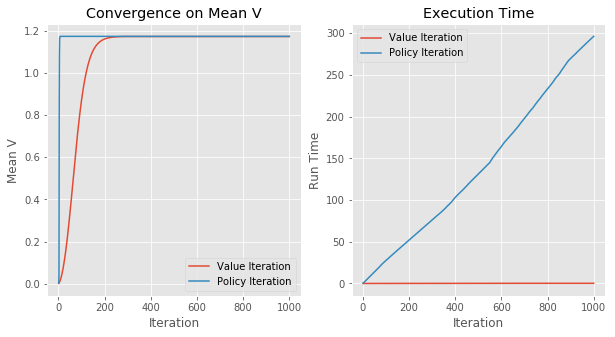

In [591]:
# Plot the convergence and time required for VI/PI
fig, ax = plt.subplots(1,2,figsize=(10,5))
large_vi_compare = large_vi_res_iter[large_vi_res_iter.gamma==GAMMA]
large_pi_compare = large_pi_res_iter[large_pi_res_iter.gamma==GAMMA]
max_iter = max(large_vi_compare['Iteration'].max(), large_pi_compare['Iteration'].max())
if large_vi_compare['Iteration'].max() < max_iter:
    fill = large_vi_compare.iloc[-1,:]
    large_vi_compare = large_vi_compare.append([fill]*(max_iter - large_vi_compare.shape[0]))
    large_vi_compare['Iteration'] = range(1, large_vi_compare.shape[0]+1)
if large_pi_compare['Iteration'].max() < max_iter:
    fill = large_pi_compare.iloc[-1,:]
    large_pi_compare = large_pi_compare.append([fill]*(max_iter - large_pi_compare.shape[0]))
    large_pi_compare['Iteration'] = range(1, large_pi_compare.shape[0]+1)

ax[0].plot(large_vi_compare['Iteration'],large_vi_compare['Mean_V'], label='Value Iteration')
ax[0].plot(large_pi_compare['Iteration'],large_pi_compare['Mean_V'], label='Policy Iteration')
ax[1].plot(large_vi_compare['Iteration'],large_vi_compare['Run Time'], label='Value Iteration')
ax[1].plot(large_pi_compare['Iteration'],large_pi_compare['Run Time'], label='Policy Iteration')
ax[0].set_title("Convergence on Mean V")
ax[0].set_ylabel("Mean V")
ax[0].set_xlabel("Iteration")
ax[0].legend()
ax[1].set_title("Execution Time")
ax[1].set_ylabel("Run Time")
ax[1].set_xlabel("Iteration")
ax[1].legend()
plt.savefig('frozenlake_large_pi_vs_vi.png', dpi=100)
plt.show()

In [609]:
#ql_result, ql_val_res = run_ql(P, R, 0.9, 20000, num_states)
MAX_ITERATION_QL = 5000000
large_ql_analysis = {'gamma': [], 'alpha':[], 'epsilon':[], 'avg reward':[], 'time':[]}
large_ql_policies = {}
large_ql_res_iter = pd.DataFrame()
large_ql_res_state = pd.DataFrame()

alpha_list = [0.1, 0.5, 0.9]

epsilon_list = [1, 0.5, 0.1]

for alpha in alpha_list:
    for gamma in [0.99]:
        for epsilon in epsilon_list:
            print (gamma, alpha, epsilon)
            ql_result, ql_val_res, ql = run_ql(large_P, large_R, rate, alpha=alpha, epsilon=epsilon, alpha_decay=1.0, epsilon_decay=0.995,
                                                      max_iter=MAX_ITERATION_QL, n_state=large_num_states)
            large_ql_policies[(gamma, alpha, epsilon)] = ql.policy
            large_ql_analysis['gamma'].append(gamma)
            large_ql_analysis['alpha'].append(alpha)
            large_ql_analysis['epsilon'].append(epsilon)
            large_ql_analysis['avg reward'].append(np.array(ql.V).mean())
            large_ql_analysis['time'].append(ql.time)
            ql_result['gamma'] = gamma
            ql_result['alpha'] = alpha
            ql_result['epsilon'] = epsilon
            ql_val_res['gamma'] = gamma
            ql_val_res['alpha'] = alpha
            ql_val_res['epsilon'] = epsilon
            large_ql_res_iter = large_ql_res_iter.append(ql_result)
            large_ql_res_state = large_ql_res_state.append(ql_val_res)


0.99 0.9 1
0.99 0.9 0.5
0.99 0.9 0.1


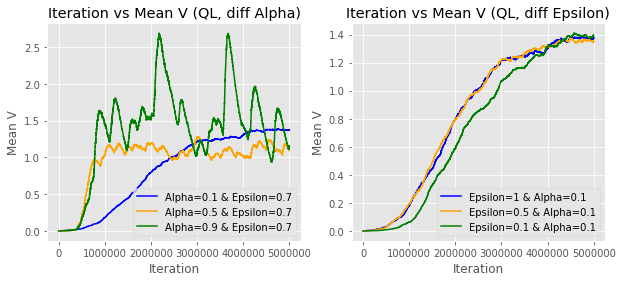

In [632]:
#ql_res_iter[(ql_res_iter.gamma == 0.99)&(ql_res_iter.alpha==0.5)&(ql_res_iter.epsilon==1.0)][['Max_V','Mean_V']].plot()

GAMMA = 0.99
colors = ['b','orange','g', 'gray', 'm']
colors_1 = ['olive','red','black', 'y']
alpha_list = [0.1, 0.5, 0.9]
fig, ax = plt.subplots(1,2, figsize=(10,4))
for i in range(len(alpha_list)):
    tmp = large_ql_res_iter[(large_ql_res_iter.gamma == GAMMA)&(large_ql_res_iter.epsilon==1.)&
                      (large_ql_res_iter['alpha']==alpha_list[i])][['Iteration','Error','Mean_V']]
    ax[0].plot(tmp['Iteration'], tmp['Mean_V'],color=colors[i], label="Alpha={} & Epsilon=0.7".format(round(alpha_list[i],3)))
    
for i in range(len(epsilon_list)):
    tmp = large_ql_res_iter[(large_ql_res_iter.gamma == GAMMA)&(large_ql_res_iter.epsilon==epsilon_list[i])&
                      (large_ql_res_iter['alpha']==0.1)][['Iteration','Error','Mean_V']]
    ax[1].plot(tmp['Iteration'], tmp['Mean_V'],color=colors[i], label="Epsilon={} & Alpha=0.1".format(round(epsilon_list[i],3)))
    #tmp = ql_res_iter[(ql_res_iter.gamma == GAMMA)&(ql_res_iter.epsilon==epsilon_list[i])&
    #                  (ql_res_iter['alpha']==0.5)][['Iteration','Error','Mean_V']]
    #ax[1].plot(tmp['Iteration'], tmp['Mean_V'],color=colors_1[i], linestyle='--', label="Epsilon={} & Alpha=0.5".format(round(epsilon_list[i],3)))

    
ax[0].set_title('Iteration vs Mean V (QL, diff Alpha)')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Mean V')
ax[0].legend()

ax[1].set_title('Iteration vs Mean V (QL, diff Epsilon)')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mean V')
ax[1].legend()
plt.savefig("frozen_lake_large_ql_plot1.png", dpi=100)
plt.show()

In [621]:
large_QL_eval_res = {'Gamma':[], 'Alpha':[], 'Epsilon':[], 'Average Total Rewards':[], 'Success Rate':[]}

for alpha in [0.1, 0.5]:
    for gamma in [0.99]:
        for epsilon in [1, 0.5]:
            total_reward, miss_pct = evaluate_policy(large_env, large_ql_policies_copy[(gamma, alpha, epsilon)], n_episodes=NUM_EPISODES_LARGE)
            large_QL_eval_res['Gamma'].append(round(gamma, 3))
            large_QL_eval_res['Alpha'].append(round(alpha,3))
            large_QL_eval_res['Epsilon'].append(epsilon)
            large_QL_eval_res['Average Total Rewards'].append(total_reward)
            large_QL_eval_res['Success Rate'].append(round(1-miss_pct, 3))

large_QL_eval_res_df = pd.DataFrame(large_QL_eval_res) 

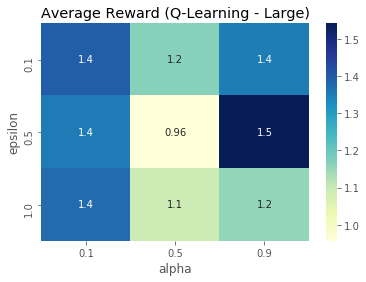

In [630]:
QL_eval_res_df_large = pd.DataFrame(ql_analysis_large)
GAMMA = 0.99
QL_comp_large = pd.pivot_table(QL_eval_res_df_large[QL_eval_res_df_large.gamma==GAMMA], values='avg reward', columns='alpha', index='epsilon')
fig, ax = plt.subplots()
ax = sns.heatmap(QL_comp_large, annot=True,  cmap="YlGnBu")
ax.set_title("Average Reward (Q-Learning - Large)")
plt.savefig("frozen_large_ql_heatmap1.png")

In [631]:
GAMMA = 0.99
best_alpha = 0.9
best_eps = 0.5
ql_result, ql_val_res, ql = run_ql(large_P, large_R, GAMMA, alpha=best_alpha, epsilon=best_eps, alpha_decay=1.0, epsilon_decay=0.995,
                                                      max_iter=MAX_ITERATION_QL, n_state=large_num_states)

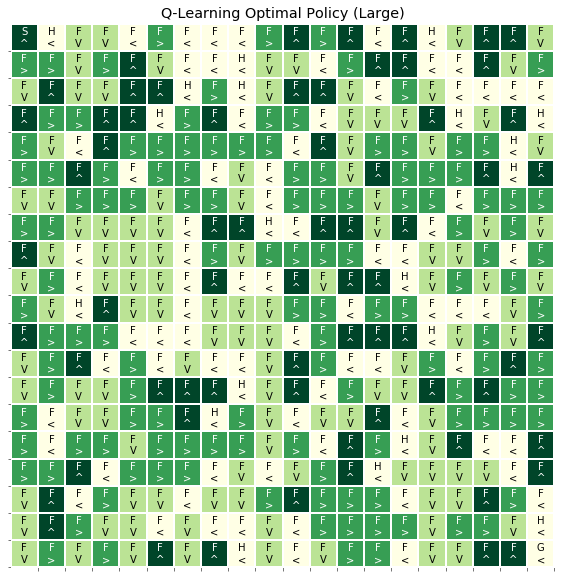

In [634]:
plot_policy(ql.policy, large_env_map, "Q-Learning Optimal Policy (Large)", save_fig=True, figsize=(10,10))

In [642]:
total_reward, miss_pct = evaluate_policy(large_env, ql.policy, n_episodes=NUM_EPISODES_LARGE)
print ("average total reward for optimal Q leraning policy is ", total_reward)

average total reward for optimal Q leraning policy is  0.0


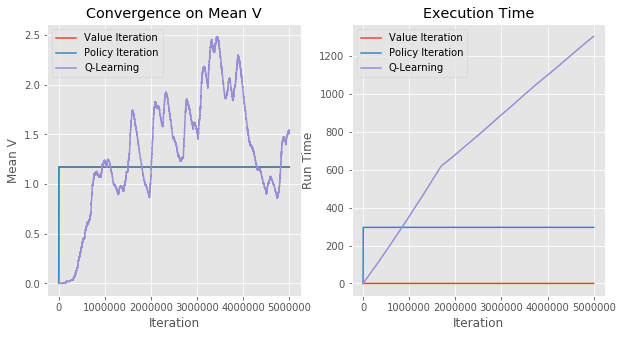

In [635]:
# Plot the convergence and time required for VI, PI and Q-Learning
fig, ax = plt.subplots(1,2,figsize=(10,5))
large_vi_compare = large_vi_res_iter[large_vi_res_iter.gamma==GAMMA]
large_pi_compare = large_pi_res_iter[large_pi_res_iter.gamma==GAMMA]
large_ql_compare = large_ql_res_iter[(large_ql_res_iter.gamma==GAMMA)&(large_ql_res_iter.alpha==best_alpha)&(large_ql_res_iter.epsilon==best_eps)]
max_iter = max(large_vi_compare['Iteration'].max(), large_pi_compare['Iteration'].max(),  large_ql_compare['Iteration'].max())
if large_vi_compare['Iteration'].max() < max_iter:
    fill = large_vi_compare.iloc[-1,:]
    large_vi_compare = large_vi_compare.append([fill]*(max_iter - large_vi_compare.shape[0]))
    large_vi_compare['Iteration'] = range(1, large_vi_compare.shape[0]+1)
if large_pi_compare['Iteration'].max() < max_iter:
    fill = large_pi_compare.iloc[-1,:]
    large_pi_compare = large_pi_compare.append([fill]*(max_iter - large_pi_compare.shape[0]))
    large_pi_compare['Iteration'] = range(1, large_pi_compare.shape[0]+1)

ax[0].plot(large_vi_compare['Iteration'],large_vi_compare['Mean_V'], label='Value Iteration')
ax[0].plot(large_pi_compare['Iteration'],large_pi_compare['Mean_V'], label='Policy Iteration')
ax[0].plot(large_ql_compare['Iteration'],large_ql_compare['Mean_V'], label='Q-Learning')
ax[1].plot(large_vi_compare['Iteration'],large_vi_compare['Run Time'], label='Value Iteration')
ax[1].plot(large_pi_compare['Iteration'],large_pi_compare['Run Time'], label='Policy Iteration')
ax[1].plot(large_ql_compare['Iteration'],large_ql_compare['Run Time'], label='Q-Learning')
ax[0].set_title("Convergence on Mean V")
ax[0].set_ylabel("Mean V")
ax[0].set_xlabel("Iteration")
ax[0].legend()
ax[1].set_title("Execution Time")
ax[1].set_ylabel("Run Time")
ax[1].set_xlabel("Iteration")
ax[1].legend()
plt.savefig('frozenlake_large_ql_comparison.png', dpi=100)
plt.show()

# End